In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [122]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px
import seaborn as sns

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,8)

# Использование cufflinks в офлайн-режиме
import cufflinks
cufflinks.go_offline()

# Настройка глобальной темы cufflinks
cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [123]:
df = pd.read_csv('AER_credit_card_data.txt')

In [124]:
df.card = df.card.apply(lambda x: 1 if x=='yes' else 0)

In [125]:
df_full_train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [126]:
print(len(train), len(val), len(test))

791 264 264


## Question 1

In [127]:
for col in ['reports', 'dependents', 'active', 'share']:
    fpr, tpr, thresholds = roc_curve(train.card.values, train[col].values)
    a = auc(fpr, tpr)
    print(f'{col}={a}')

reports=0.28333701393106236
dependents=0.46722427722262094
active=0.6043173411362006
share=0.989183643423692


## Question 2

In [128]:
used_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [129]:
#dict_train = train[['owner', 'selfemp']].to_dict(orient='records')
dict_train = train[used_cols].to_dict(orient='records')
dict_val = val[used_cols].to_dict(orient='records')

In [130]:
v = DictVectorizer(sparse=False)

In [131]:
v.fit(dict_train)
X_train = v.transform(dict_train)
y_train = train.card

X_val = v.transform(dict_val)
y_val = val.card

In [132]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [133]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [134]:
pred = model.predict_proba(X_val)[:, 1]

In [135]:
roc_auc_score(y_val, pred)

0.995171242063847

## Question 3

In [136]:
res = []
for t in np.linspace(0, 1, 101):
    predict = []
    for p in pred:
        if p >= t:
            predict.append(1)
        else:
            predict.append(0)
    p = precision_score(y_val, predict)
    r = recall_score(y_val, predict)
    res.append([t, p, r])

In [137]:
data = pd.DataFrame(res, columns=['t', 'p', 'r'])

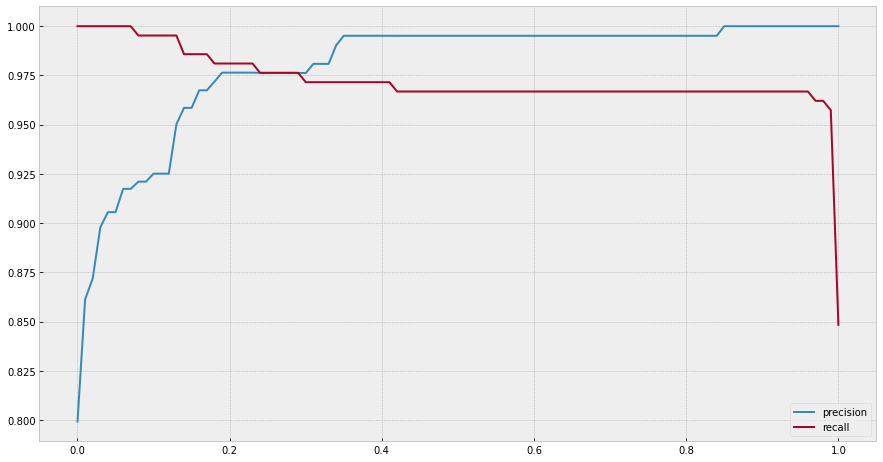

In [138]:
plt.plot(data.t, data.p, label='precision')
plt.plot(data.t, data.r, label='recall')
plt.legend()

## Question 4

In [139]:
res = []
for t in np.linspace(0, 1, 101):
    predict = []
    for p in pred:
        if p >= t:
            predict.append(1)
        else:
            predict.append(0)
    p = precision_score(y_val, predict)
    r = recall_score(y_val, predict)
    f1 = 2 * p * r / (p + r)
    res.append([t, p, r, f1])

In [140]:
data = pd.DataFrame(res, columns=['t', 'p', 'r', 'f1'])

In [141]:
data.sort_values(by='f1')

,t,p,r,f1
0,0.00,0.799242,1.000000,0.888421
100,1.00,1.000000,0.848341,0.917949
1,0.01,0.861224,1.000000,0.925439
2,0.02,0.871901,1.000000,0.931567
3,0.03,0.897872,1.000000,0.946188
...,...,...,...,...
38,0.38,0.995146,0.971564,0.983213
40,0.40,0.995146,0.971564,0.983213
35,0.35,0.995146,0.971564,0.983213
41,0.41,0.995146,0.971564,0.983213


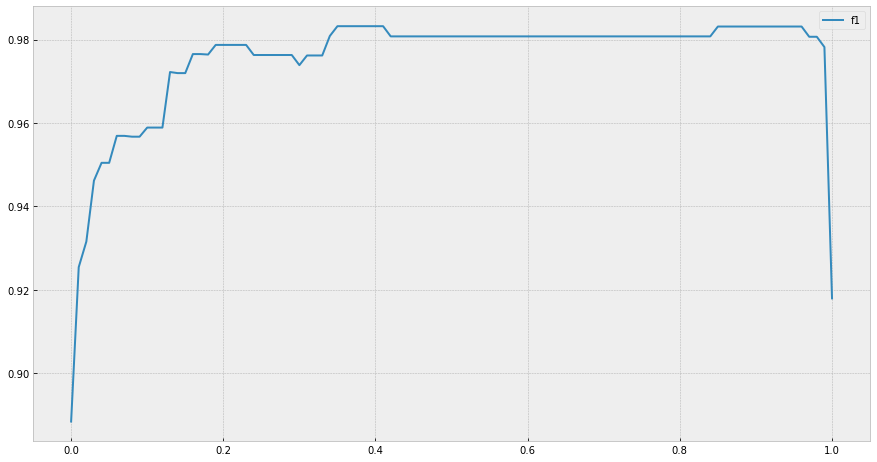

In [142]:
plt.plot(data.t, data.f1, label='f1')
plt.legend()

## Question 5

In [151]:
def train(df, y, c=1.0):
    dicts = df[used_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y)
    
    return dv, model

In [146]:
dv, model = train(df_full_train, df_full_train.card)

In [147]:
def predict(df, dv, model):
    dicts = df[used_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [148]:
y_pred = predict(test, dv, model)

In [149]:
from sklearn.model_selection import KFold

In [150]:
n_splits = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


## Question 6

In [152]:
n_splits = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for c in [0.01, 0.1, 1, 10]:
    print(c)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.01
0.992 +- 0.006
0.1
0.993 +- 0.005
1
0.994 +- 0.005
10
0.995 +- 0.004
